# Import

In [4]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import sklearn
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler

import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time


# Global params

In [2]:
DEVICE = "cpu"
ROOT = os.getcwd()
ENV_NAME = 'MountainCarContinuous-v0'
OUTPUT = os.path.join(ROOT, 'output', ENV_NAME)

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)


# Test env

state size =  (2,)
action size =  (1,)


  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 40.04it/s]

sample action 
[0.2819309]
(1,)
<class 'numpy.ndarray'>


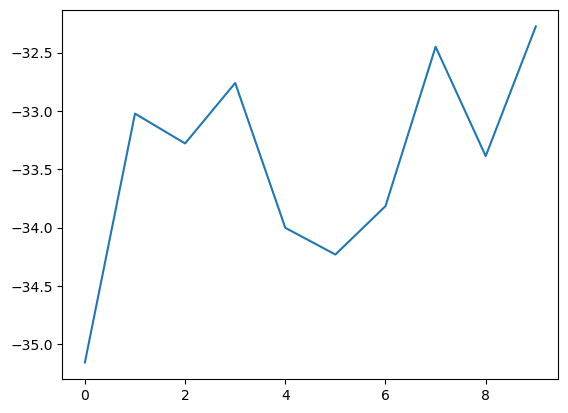

In [3]:
env = gym.make(ENV_NAME)
obs, info = env.reset()
print('state size = ', env.observation_space.shape)
print('action size = ', env.action_space.shape)

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    
    rewards.append(total_reward)

print('sample action ')
print(action)
print(action.shape)
print(type(action))
sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

In [5]:
env = gym.make(ENV_NAME)

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)
# env.seed(args.seed)
# torch.manual_seed(args.seed)
featurizer = sklearn.pipeline.FeatureUnion([
  ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
  ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
  ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
  ("rbf4", RBFSampler(gamma=0.5, n_components=100))
])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [6]:
def process_state(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

# Actor and Critic Net for continous space

In [10]:
class Actor(nn.Module):
  def __init__(self):
    super(Actor, self).__init__()
    self.fc_mu = nn.Linear(400, 1)
    self.fc_sigma = nn.Linear(400, 1)
    init.xavier_normal_(self.fc_mu.weight)
    init.xavier_normal_(self.fc_sigma.weight)

  def forward(self, x):
    mu = self.fc_mu(x)
    sigma = F.softplus(self.fc_sigma(x)) + 1e-5
    return mu, sigma

class Critic(nn.Module):
  def __init__(self):
    super(Critic, self).__init__()
    self.fc_value = nn.Linear(400, 1)
    init.xavier_normal_(self.fc_value.weight)

  def forward(self, x):
    value = self.fc_value(x)
    return value

actor = Actor()
critic = Critic()
actor_lr = 1e-3
critic_lr = 5e-4
gamma = 0.99

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=actor_lr)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=critic_lr)

In [15]:
def get_action(state):
  state = torch.from_numpy(process_state(state)).float()
  action_mu, action_sigma = actor(state)
  action_dist = torch.distributions.normal.Normal(action_mu, action_sigma)
  action = action_dist.sample()
  action = torch.clamp(action, float(env.action_space.low[0]), float(env.action_space.high[0]))
  return action.item()

def get_state_value(state):
  state = torch.from_numpy(process_state(state)).float()
  state_value = critic(state)
  return state_value.item()

def update_actor(state, action, advantage):
  state = torch.from_numpy(process_state(state)).float()
  action_mu, action_sigma = actor(state)
  action_dist = torch.distributions.normal.Normal(action_mu, action_sigma)
  act_loss = -action_dist.log_prob(torch.tensor(action)) * advantage
  entropy = action_dist.entropy()
  loss = act_loss - 1e-4 * entropy
  actor_optimizer.zero_grad()
  loss.backward()
  actor_optimizer.step()
  return

def update_critic(state, target):
  state = torch.from_numpy(process_state(state)).float()
  state_value = critic(state)
  loss = F.mse_loss(state_value, torch.tensor(target))
  critic_optimizer.zero_grad()
  loss.backward()
  critic_optimizer.step()
  return


# Training

In [16]:
stats = []

loop = tqdm(range(100))
for i_episode in loop:
    state = env.reset()
    episode_score = 0
    for t in count():
        action = get_action(state)
        next_state, reward, done, _ = env.step([action])
        episode_score += reward

        target = reward + gamma * get_state_value(next_state)
        td_error = target - get_state_value(state)

        update_actor(state, action, advantage=td_error)
        update_critic(state, target)

        if done:
            break

        state = next_state

    stats.append(episode_score)
    if np.mean(stats[-100:]) > 90 and len(stats) >= 101:
        print(np.mean(stats[-100:]))
        print("Solved")
    print("Episode: {}, reward: {}.".format(i_episode, episode_score))




  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.